
## Steps:
The project involved 3 phases.
1. Gathering data using Selenium in python.
2. Labelling it.
3. Building the Machine Learning Model.
4. Deploying the Model.

We will explore the Machine Learning aspect in this notebook. You can check my code for the other two modules in my [github](https://github.com/SakethSigma).



## Code Summary:
1. **Data Import and Feature Extraction**
    - 1.1 Importing Libraries & Data
    - 1.2 Understanding Data
    - 1.3 Extracting Age and Location
    - 1.4 Pre-processing the Bio column
2. **Data Analysis**
    - 2.1 Class Distribution
    - 2.2 Distribution of Classes By City
    - 2.3 Distribution of Classes By Age
    - 2.4 Scatterplot of Bio length & Questions Answered
    - 2.5 Most Common Words in Bio
3. **Training the Model**
    - 3.1 Train-Test Split
    - 3.2 Scaling the features
    - 3.3 TF-IDF Vectorize
    - 3.4 Base Model Comparison
    - 3.5 Hyperparameter Tuning with GridSearchCV
    - 3.6 Plotting the Learning Curves
    - 3.7 Feature Importances
    - 3.8 Model Prediction Correlations
    - 3.9 Building the ensemble model
    - 3.10 Learning Curve of ensemble model
4. **Testing the Model**
    - 4.1 Classification Report
    - 4.2 Confusion Matrix
    - 4.3 Misclassified test data



# Code 

## 1. Data Import and Feature Extraction

**1.1 Importing Libraries and Data**

In [511]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
nlp = spacy.load('en_core_web_sm')

In [512]:
df = pd.read_csv('okC.csv')

**1.2 Understanding Data** <br>
The dataset contains 492 samples and 7 columns.
- **Age** . Location - Combined Column of Age and Location seperated by '.'
- **Bio** - A short bio the person writes to introduce themself
- **Agree** - Number of answers to questions that match with my profile
- **Disagree**- Number of answers to questions that do not match with my profile.
- **Find Out** - Number of Questions which have been answered by one of us and not the other.
- **Ques_Ans** - Total Questions Answered: Sum of Agree, Disagree and Find Out.
- **Labels** - 
    <br>&nbsp;&nbsp;a. **'Ok'** - The profile is ok and can be swiped right
    <br>&nbsp;&nbsp;b. **'Fake'** - The profile is fake. Usually someone catfishing or trying to phish/hack.
    <br>&nbsp;&nbsp;c. **'Low Info'** - The profile didn't have enough information. This can be either genuine or Fake but we aren't interested in these profiles, so we will group &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;them with Fake.

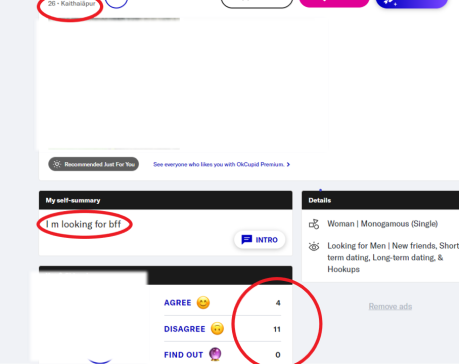

In [513]:
df.tail()

,Age . Location,Bio,Agree,Disagree,Find Out,Ques_Ans,Label
488,22 • Hyderābād,"Loyal,honest,hard working",27,19,4,50,Ok
489,27 • Delhi,An old soul with a sage's wisdom and a child's...,22,9,1,32,Ok
490,22 • Hyderābād,This is valcano ...bold and wild and open ment...,18,23,4,45,Fake
491,27 • New Delhi,"Well, total crazy one, weirdo, funny and extre...",29,27,102,158,Ok
492,27 • New Delhi,Just be yourself there is no one better🌼,6,5,4,15,Ok


**1.3 Extracting Age & Location**

The Age & location are in a single column. We seperate them into two columns.

In [514]:
df[['Age', 'Location']] = df['Age . Location'].str.split("• ",expand=True)

In [515]:
df['Age'] = pd.to_numeric(df['Age'])
df['Ques_Ans'] = pd.to_numeric(df['Ques_Ans'])

In [516]:
df = df.drop(['Agree','Disagree','Find Out'],axis=1)

In [517]:
df.head()

,Age . Location,Bio,Ques_Ans,Label,Age,Location
0,20 • Mumbai,I doubt you are gonna read this but still...\n...,41,Ok,20,Mumbai
1,22 • Chandrapur,would love to talk to some Bollywood sort of r...,15,Ok,22,Chandrapur
2,21 • Kolkata,"ig @_.jhinuk\n\n#5'7""\n#ambivert\n#night_owl\n...",89,Ok,21,Kolkata
3,22 • Thāne,Not so good at that\nMy ig - Shrutiidash,24,Ok,22,Thāne
4,26 • Pallipuram,Ping me on Instagram at srishtikpr9,15,Low Info,26,Pallipuram


In [518]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age . Location  493 non-null    object
 1   Bio             483 non-null    object
 2   Ques_Ans        493 non-null    int64 
 3   Label           493 non-null    object
 4   Age             493 non-null    int64 
 5   Location        493 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.2+ KB


**1.4 Pre-processing the Bio column**

There are 10 Bios with missing values. We fill them with empty string

In [519]:
#filling empty Bios with empty string
df['Bio'] = df['Bio'].fillna(' ')

### We treat the Bio-Feature in 3 ways:
1. Convert all text to lowercase 
2. Group all similar-sized numbers into a string. This has been done because fake profiles tend to have a high incidence of phone numbers and a 10-digit number could be a useful feature to separate the classes. 
3. Group all emojis to the word 'emoji'.
4. Remove punctuation.

<b><u>Bio Pre-processing Demo</b></u>

<b>Unprocessed</b>: My Name is Test. You can contact me on 9999999999 <br>
<b>Processed</b>: my name is test you can contact me on 10_Digit_Num <br>
<b>Unprocessed</b>: I like tea ☕<br>
<b>Processed</b>: i like tea   emoji <br>

In [520]:
test_string_1 = 'My Name is Test. You can contact me on 9999999999'
test_string_2 = 'I like tea ☕'
print(f"Unprocessed: {test_string_1}")
print(f"Processed: {prepro_string(test_string_1)}")
print(f"Unprocessed: {test_string_2}")
print(f"Processed: {prepro_string(test_string_2)}")


Unprocessed: My Name is Test. You can contact me on 9999999999
Processed: my name is test you can contact me on 10_Digit_Num 
Unprocessed: I like tea ☕
Processed: i like tea 


In [521]:
##Function to count length of bio
def get_char_counts(string):
    #initialized value
    total_digits = 0
    total_letters = 0

    # iterate through all characters
    for s in string:

        # if character is digit (return True)
        if s.isnumeric():
            total_digits += 1

        # if character is letter (return False)
        else:
            total_letters += 1
    return total_digits, total_letters

In [522]:
## Function to pre-process string. Replace emojis and numbers with strings.
def prepro_string(bio):
    bio = str(bio)
    bio = remove_emoji(bio.lower()) ## Parse Emojis
    new_bio = '';
    bio = bio.replace("\n","")  #Removes newline characters
    doc = nlp(bio)
    
    for tok in doc:             ##Convert Digits into Digit(Num_digits) Format.

        if tok.is_digit:
            digit_len = len(tok)
            new_bio += str(digit_len) + '_Digit_' + 'Num'  + ' '
        else:
            new_bio += tok.text + ' '

    return new_bio

In [523]:
## Function to remove emojis and replace them with the string-'emoji' & remove punctuation
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]", flags=re.UNICODE)
    
    string = re.sub(r'[^\w\s]', '', string)


    return emoji_pattern.sub(' emoji ', string)

In [524]:
## Getting number of characters and number of digits in the Bio.
applied_df = df.apply(lambda row: get_char_counts(row.Bio), axis='columns', result_type='expand')
df = pd.concat([df, applied_df], axis='columns')
df = df.rename(columns={0:'Num_Digits',1:'Num_Chars'})

In [525]:
#Applying Preprocessing Function to Bio
df['Bio'] = df['Bio'].apply(prepro_string)

In [526]:
df

,Age . Location,Bio,Ques_Ans,Label,Age,Location,Num_Digits,Num_Chars
0,20 • Mumbai,i doubt you are gon na read this but stilltea ...,41,Ok,20,Mumbai,4,854
1,22 • Chandrapur,would love to talk to some bollywood sort of r...,15,Ok,22,Chandrapur,0,57
2,21 • Kolkata,ig _ jhinuk57ambivertnight_owlmusic_lovermathe...,89,Ok,21,Kolkata,2,169
3,22 • Thāne,not so good at thatmy ig shrutiidash,24,Ok,22,Thāne,0,39
4,26 • Pallipuram,ping me on instagram at srishtikpr9,15,Low Info,26,Pallipuram,1,34
...,...,...,...,...,...,...,...,...
488,22 • Hyderābād,loyalhonesthard working,50,Ok,22,Hyderābād,0,25
489,27 • Delhi,an old soul with a sages wisdom and a childs h...,32,Ok,27,Delhi,0,337
490,22 • Hyderābād,this is valcano bold and wild and open mentali...,45,Fake,22,Hyderābād,3,273
491,27 • New Delhi,well total crazy one weirdo funny and extremel...,158,Ok,27,New Delhi,0,62


*Fake Profiles and Low Info Profiles have been mapped to 1*

In [527]:
#Mapping Labels to Numeric Values
df['Label'] = df['Label'].map({'Ok':0,'Low Info':1,'Fake':1})

In [528]:
df.tail()

,Age . Location,Bio,Ques_Ans,Label,Age,Location,Num_Digits,Num_Chars
488,22 • Hyderābād,loyalhonesthard working,50,0,22,Hyderābād,0,25
489,27 • Delhi,an old soul with a sages wisdom and a childs h...,32,0,27,Delhi,0,337
490,22 • Hyderābād,this is valcano bold and wild and open mentali...,45,1,22,Hyderābād,3,273
491,27 • New Delhi,well total crazy one weirdo funny and extremel...,158,0,27,New Delhi,0,62
492,27 • New Delhi,just be yourself there is no one better,15,0,27,New Delhi,0,40


## 2. Data Analysis

**2.1 Class Distribution**

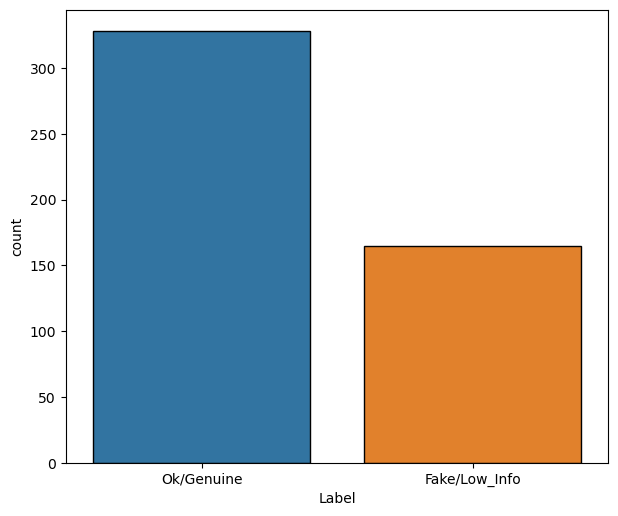

In [529]:
plt.figure(figsize=(7,6),dpi=100)
k = sns.countplot(data=df,x='Label',edgecolor='black',linewidth=1)
k.set_xticklabels(['Ok/Genuine','Fake/Low_Info']);

**2.2 Distribution of Classes By City**

In [530]:
loc_counts = df.groupby(['Location','Label']).count()['Age'].unstack().fillna(0).sort_values(by=0,ascending=False)[:10]

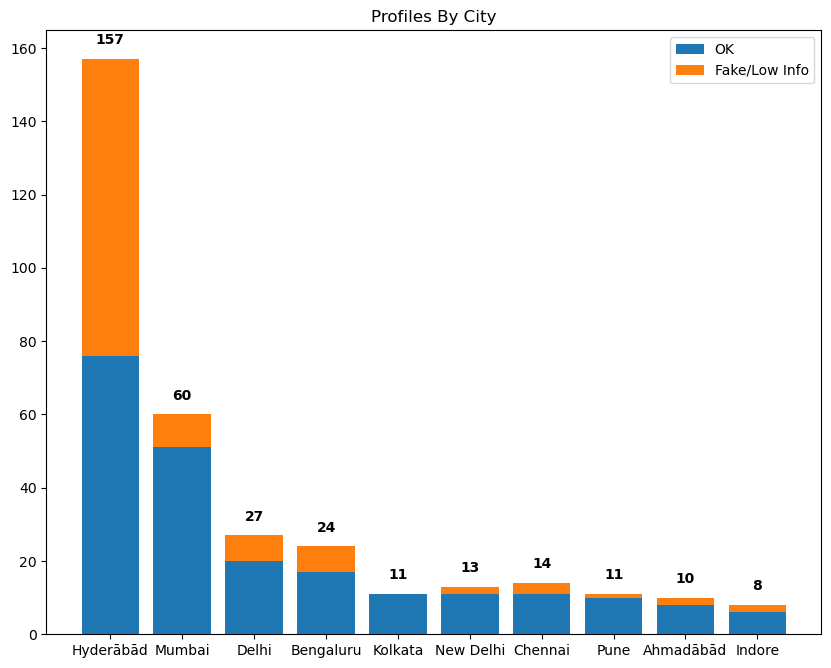

In [531]:
fig, ax = plt.subplots(figsize=(10,8),dpi=100)
# First plot the 'Okay' bars for every day.
ax.bar(loc_counts.index, loc_counts[0], label='OK')
# Then plot the 'Fake' bars on top, starting at the top of the 'Okay'
# bars.
ax.bar(loc_counts.index, loc_counts[1], bottom=loc_counts[0],
       label='Fake/Low Info')


# Sum up the rows of our data to get the total value of each bar.
totals = loc_counts.sum(axis=1)
# Set an offset that is used to bump the label up a bit above the bar.
y_offset = 4
# Add labels to each bar.
for i, total in enumerate(totals):
  ax.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold')

ax.set_title('Profiles By City');
ax.legend();

*This might not necessarily indicate actual distribution of classes in the app itself as the profiles I get access to are personalized*

**2.3 Distribution of Classes By Age**

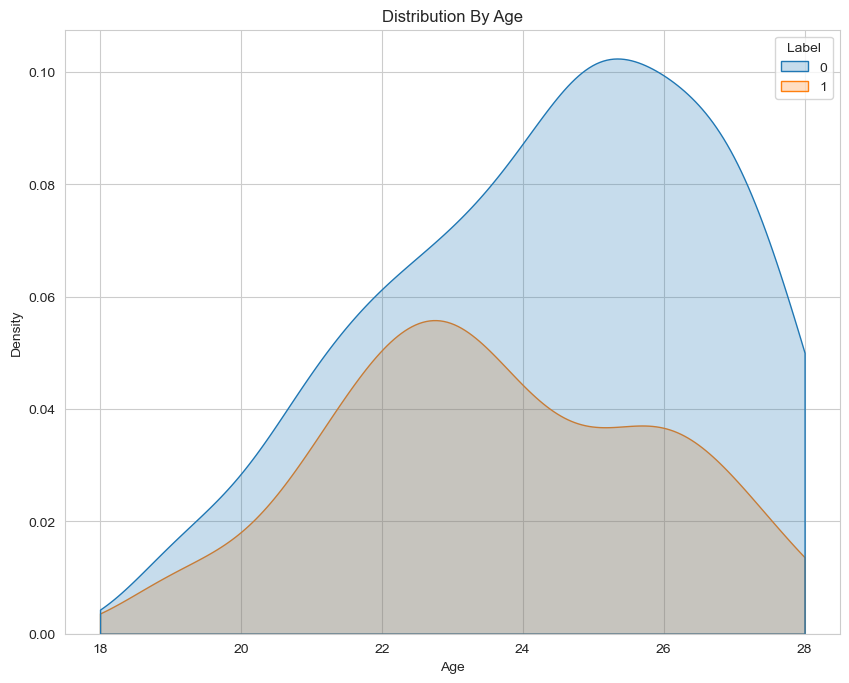

In [532]:
plt.figure(figsize=(10,8),dpi=100)
sns.set_style("whitegrid")
sns.kdeplot(data=df,x='Age',fill=True,hue='Label',clip=[18,28]);
plt.title('Distribution By Age');

**2.4 Scatterplot of Bio length & Questions Answered**

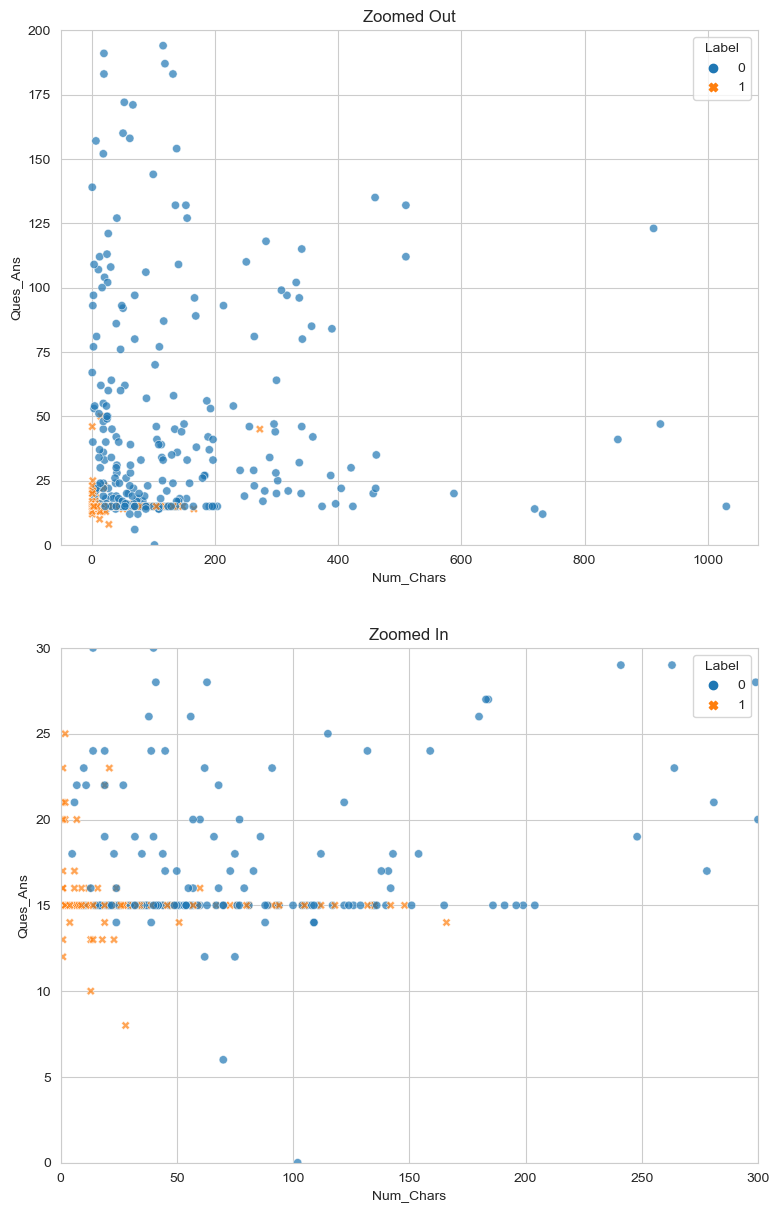

In [533]:

fig, axes = plt.subplots(figsize=(9,15),nrows=2,dpi=100)
sns.scatterplot(data=df,x='Num_Chars',y='Ques_Ans',alpha = 0.7,hue='Label',style='Label',ax=axes[0])
axes[0].set_ylim(0,200)
axes[0].set_title('Zoomed Out');
sns.scatterplot(data=df,x='Num_Chars',y='Ques_Ans',alpha = 0.7,hue='Label',style='Label',ax=axes[1])
axes[1].set_ylim(0,30)
axes[1].set_xlim(0,300)
axes[1].set_title('Zoomed In');

*We can see a seperation of classes in the Zoomed-In plot. Fake Profiles tend to have shorter Bios and lesser No. of Questions Answered.*

In [534]:
df.tail()

,Age . Location,Bio,Ques_Ans,Label,Age,Location,Num_Digits,Num_Chars
488,22 • Hyderābād,loyalhonesthard working,50,0,22,Hyderābād,0,25
489,27 • Delhi,an old soul with a sages wisdom and a childs h...,32,0,27,Delhi,0,337
490,22 • Hyderābād,this is valcano bold and wild and open mentali...,45,1,22,Hyderābād,3,273
491,27 • New Delhi,well total crazy one weirdo funny and extremel...,158,0,27,New Delhi,0,62
492,27 • New Delhi,just be yourself there is no one better,15,0,27,New Delhi,0,40


In [535]:
## Importing for Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn import model_selection

In [536]:
## Importing Classification Models and reports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,f1_score
from sklearn.ensemble import VotingClassifier


**2.5 Most Common Words in Bio**

In [538]:
pos = df[df['Label'] == 1]
neg = df[df['Label'] == 0]
cv = CountVectorizer(stop_words='english');
cv.fit(pos);

In [549]:
matrix = cv.fit_transform(df[df['Label']==0]['Bio'])
freqs = zip(cv.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print("Top 15 words used for Genuine Profiles\n")
out = sorted(freqs, key=lambda x: -x[1])
for i in range(15):
    print(out[i])

Top 15 words used for Genuine Profiles

('nt', 75)
('looking', 61)
('like', 50)
('love', 49)
('new', 37)
('good', 36)
('person', 29)
('know', 28)
('girl', 27)
('just', 26)
('friends', 23)
('time', 23)
('people', 22)
('simple', 22)
('life', 21)


In [548]:
matrix = cv.fit_transform(df[df['Label']==1]['Bio'])
freqs = zip(cv.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print("Top 15 words used for Fake/Low_Info Profiles\n")
out = sorted(freqs, key=lambda x: -x[1])
for i in range(15):
    print(out[i])

Top 15 words used for Fake/Low_Info Profiles

('whatsapp', 29)
('10_digit_num', 23)
('number', 16)
('hi', 13)
('emoji', 12)
('love', 8)
('hey', 6)
('friendship', 5)
('fun', 5)
('looking', 5)
('2_digit_num', 4)
('come', 4)
('guys', 4)
('iam', 4)
('like', 4)


## 3. Training the Model

The Location & Age features might lead to overfitting, so we drop it along with Age.Loc

In [154]:
X = df.drop(['Age . Location','Location','Num_Digits','Age'],axis=1)
y = df['Label']

In [155]:
X.tail()

,Bio,Ques_Ans,Label,Num_Chars
488,loyalhonesthard working,50,0,25
489,an old soul with a sages wisdom and a childs h...,32,0,337
490,this is valcano bold and wild and open mentali...,45,1,273
491,well total crazy one weirdo funny and extremel...,158,0,62
492,just be yourself there is no one better,15,0,40


In [156]:
y.value_counts()

0    328
1    165
Name: Label, dtype: int64

**3.1 Train-Test Split**

In [157]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=101)

**3.2 Scaling the features**

In [433]:
## Scaling Features
scaler = StandardScaler()
scaled_X_train_nums = scaler.fit_transform(X_train[['Ques_Ans','Num_Chars']])
scaled_X_test_nums = scaler.transform(X_test[['Ques_Ans','Num_Chars']])

**3.3 TF-IDF Vectorize**

In [431]:
tf_idf = TfidfVectorizer(stop_words='english',min_df=12)
X_train_gram = tf_idf.fit_transform(X_train['Bio'])
X_test_gram = tf_idf.transform(X_test['Bio'])

Adding Scaled Features to TF-IDF Vectorized Bio Sparse Matrix

In [434]:
#Train Data
train_arr = np.array(scaled_X_train_nums)
M_train = sparse.coo_matrix(train_arr)
sparse_X_train = sparse.hstack((M_train,X_train_gram ))
#Test Data
test_arr = np.array(scaled_X_test_nums)
M_test = sparse.coo_matrix(test_arr)
sparse_X_test = sparse.hstack((M_test, X_test_gram))

**3.4 Base Model Comparison**

In [435]:
random_state = 101

In [436]:
#Defining Models
random_state = 101
models = [
          ('LogReg', LogisticRegression(random_state=random_state)), 
          ('RF', RandomForestClassifier(random_state=random_state)),
          ('KNN', KNeighborsClassifier()),
          ('SVC', SVC(random_state=random_state)), 
          ('ABC', AdaBoostClassifier(random_state=random_state)),
          ('GB', GradientBoostingClassifier(random_state=random_state))
        ]
results = []
names = []
scoring = ['accuracy','f1','precision','recall']

In [437]:
for name, model in models:
        skfold = model_selection.StratifiedKFold(n_splits=10)
        cv_results = model_selection.cross_validate(model, sparse_X_train, y_train, cv=skfold, scoring=scoring)
        names.append(name)
        mean_acc = np.mean(cv_results['test_accuracy'])
        mean_f1 = np.mean(cv_results['test_f1'])
        mean_precision = np.mean(cv_results['test_precision'])
        mean_recall = np.mean(cv_results['test_recall'])
        

        #results.append(pd.DataFrame(cv_results)[['test_accuracy','test_f1']].mean())
        results.append([name,mean_acc,mean_f1,mean_precision,mean_recall])

Base Models Performance Comparison. We choose F1 score to compare the models

In [438]:
pd.DataFrame(results,columns=['Model','mean_accuracy','mean_f1','mean_precision','mean_recall'])

,Model,mean_accuracy,mean_f1,mean_precision,mean_recall
0,LogReg,0.845192,0.764204,0.789096,0.745604
1,RF,0.842628,0.760204,0.799432,0.736264
2,KNN,0.817372,0.721068,0.748247,0.699451
3,SVC,0.817436,0.734906,0.717453,0.760440
4,ABC,0.832500,0.747361,0.774456,0.744505
5,GB,0.862949,0.783171,0.845890,0.736264


In [439]:
kfold = StratifiedKFold(n_splits=10)

In [440]:
cv_results = []
for name,classifier in models :
    cv_results.append(cross_val_score(classifier, sparse_X_train, y = y_train, scoring = "f1", cv = kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())



In [441]:
cv_res = pd.DataFrame({"Algorithms":["LogReg","RF","KNN","SVC","ABC","GB"],"CrossValMeans":cv_means,"CrossValerrors": cv_std
                       })

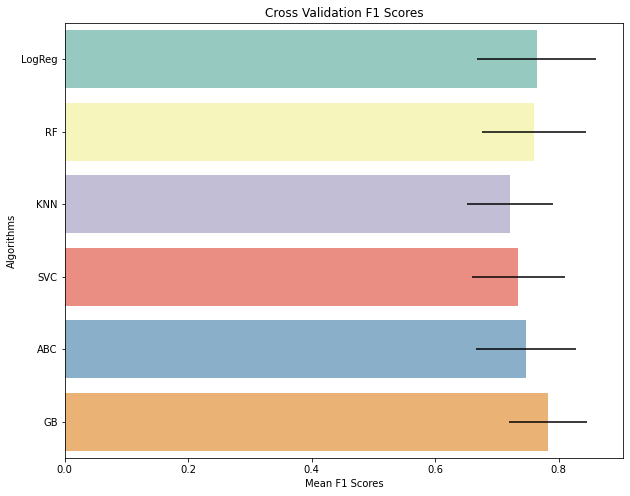

In [443]:
plt.figure(figsize=(10,8))
g = sns.barplot(data = cv_res,x="CrossValMeans",y="Algorithms", palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean F1 Scores")
g = g.set_title("Cross Validation F1 Scores")

**3.5 Hyperparameter Tuning with GridSearchCV**

In [444]:
# LogReg Parameters Tuning

LR = LogisticRegression()

## Search grid for optimal parameters
lr_param_grid = {"penalty":['elasticnet'],
                 "C": np.logspace(-2,3,10),
                 "max_iter": [1000000],
                 "solver": ['saga'],
                 "l1_ratio": [0.1,0.3,0.5,0.7,0.8,0.9,0.95,1]}

gsLR = GridSearchCV(LR,param_grid=lr_param_grid, cv=kfold,scoring="f1",n_jobs=6,verbose=1)

gsLR.fit(sparse_X_train,y_train)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


0.8058447340983493

In [490]:
gsLR.best_estimator_

LogisticRegression(C=0.464158883361278, l1_ratio=1, max_iter=1000000,
                   penalty='elasticnet', solver='saga')

In [445]:
# KNN Parameters Tuning
KNN = KNeighborsClassifier()

## Search grid for optimal parameters
knn_param_grid = {"n_neighbors": np.arange(1,50)}

gsKNN = GridSearchCV(KNN,param_grid=knn_param_grid,cv=kfold,scoring="f1",n_jobs=6,verbose=1)

gsKNN.fit(sparse_X_train,y_train)

KNN_best = gsKNN.best_estimator_

#Best Score
gsKNN.best_score_

Fitting 10 folds for each of 49 candidates, totalling 490 fits


0.7986428354254441

In [446]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": np.arange(2,8),
              "max_features": [2,4,6],
              "bootstrap": [True],
              "n_estimators" :[100,200,300,400],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 6, verbose = 1)

gsRFC.fit(sparse_X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8095813606683171

In [447]:
RFC_best

RandomForestClassifier(max_depth=6, max_features=6, n_estimators=300)

In [448]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300,400],
              'learning_rate': [0.1],
              'max_depth': [1,2,3],
               "max_features": [6,8,10],
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1", n_jobs= 6, verbose = 1)

gsGBC.fit(sparse_X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.8098632368797286

In [449]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [0.1,0.5,0.7, 1],
                  'C': [75,80,85],
                 'class_weight':['balanced',None]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="f1", n_jobs= 6, verbose = 1)

gsSVMC.fit(sparse_X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


0.7869792531861497

In [451]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=101)

ada_param_grid = {"base_estimator__criterion" : ["gini"],
                  "base_estimator__max_features": ["sqrt","log2","auto"],
                  "algorithm" : ["SAMME"],
                  "n_estimators": [100,200],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1", n_jobs= 6, verbose = 1)

gsadaDTC.fit(sparse_X_train,y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_



Fitting 10 folds for each of 42 candidates, totalling 420 fits


0.7678127859147349

In [452]:
ada_best

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_features='sqrt'),
                   learning_rate=0.1, n_estimators=200, random_state=101)

**3.6 Plotting the Learning Curves**

In [453]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


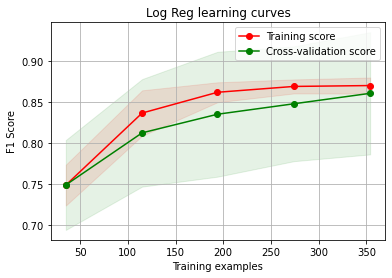

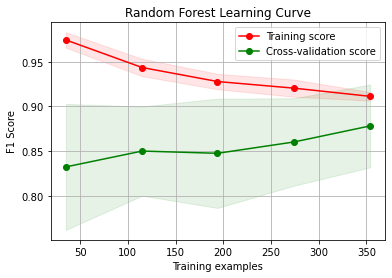

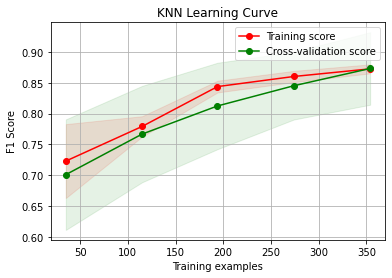

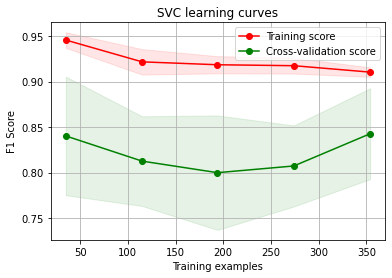

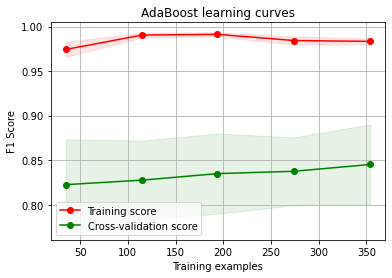

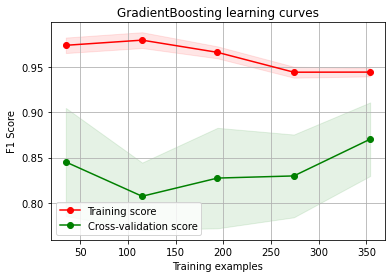

In [454]:
g = plot_learning_curve(gsLR.best_estimator_,"Log Reg learning curves",sparse_X_train,y_train,cv=kfold)
g = plot_learning_curve(gsRFC.best_estimator_,"Random Forest Learning Curve",sparse_X_train,y_train,cv=kfold)
g = plot_learning_curve(gsKNN.best_estimator_,"KNN Learning Curve",sparse_X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",sparse_X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",sparse_X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",sparse_X_train,y_train,cv=kfold)

**Observations**
- Logistic Regression and KNN are fitting well.
- GradientBoost & SVC are overfitting but their performance could improve with more trainng data as indicated by converging validation curves
- AdaBoost is not suited for this task.

**3.7 Feature Importances**

In [455]:
words = tf_idf.get_feature_names()
features = ['Ques_Ans','Num_Chars']
features.extend(words)

In [457]:
rf_feat_imp = pd.DataFrame(RFC_best.feature_importances_,index=features
                           ,columns=['Feature_Imp_RandomForest']).sort_values(ascending=False
                                                                              ,by='Feature_Imp_RandomForest')[0:20]

Text(0.5, 1.0, 'Random Forest Feature Importance')

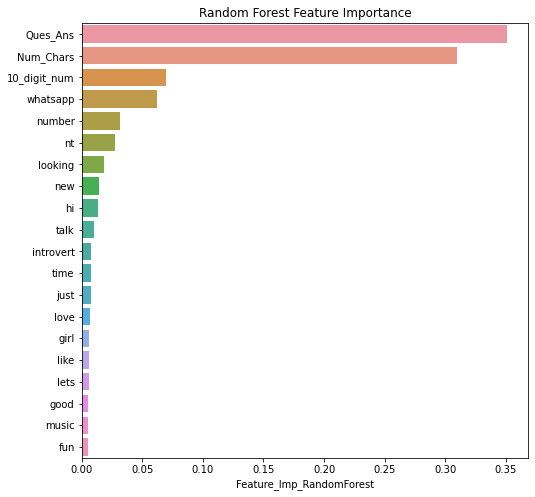

In [487]:
plt.figure(figsize=(8,8))
sns.barplot(data=rf_feat_imp,x='Feature_Imp_RandomForest',y=rf_feat_imp.index)
plt.title('Random Forest Feature Importance')

In [459]:
lr_feat_imp = pd.DataFrame(LR_best.coef_,columns=features,index=['Feature_Imp_LogReg']).transpose()
lr_feat_imp = lr_feat_imp[lr_feat_imp['Feature_Imp_LogReg'] != 0]

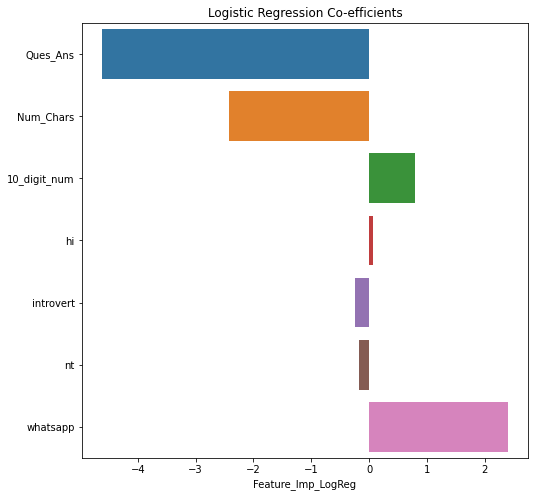

In [489]:
plt.figure(figsize=(8,8))
sns.barplot(data=lr_feat_imp,x='Feature_Imp_LogReg',y=lr_feat_imp.index);
plt.title('Logistic Regression Co-efficients');

Because we used elastic net and got best l1 ratio as 1, Lasso Regression has eliminated all the unnecessary features and the model is very easily interpretible.

**3.8 Model Prediction Correlations**

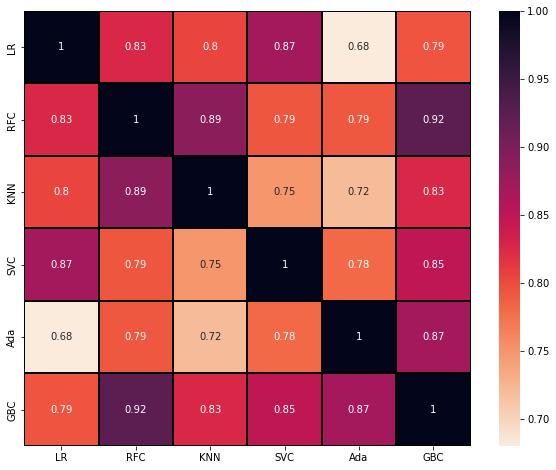

In [461]:
train_LR = pd.Series(LR_best.predict(sparse_X_train), name="LR")
train_RFC = pd.Series(RFC_best.predict(sparse_X_train), name="RFC")
train_KNN = pd.Series(KNN_best.predict(sparse_X_train),name = "KNN")
train_SVMC = pd.Series(SVMC_best.predict(sparse_X_train), name="SVC")
train_AdaC = pd.Series(ada_best.predict(sparse_X_train), name="Ada")
train_GBC = pd.Series(GBC_best.predict(sparse_X_train), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([train_LR,train_RFC,train_KNN,train_SVMC,train_AdaC,train_GBC],axis=1)

plt.figure(figsize=(10,8))
g= sns.heatmap(ensemble_results.corr(),annot=True,cmap='rocket_r',linecolor='black',linewidth=2)

**Observations**
1. RFC has high correlation with  KNN & GBC.
2. Ada has low correlations with KNN and LR.

**3.9 Building the ensemble model**

I considered LR, RF and KNN models for the ensemble as their learning curves indicate good fit.

In [491]:
models = [ ('LR',LR_best),
          ('RF',RFC_best),
          ('KNN',KNN_best),
        ]

In [492]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(
 estimators=models, final_estimator=LogisticRegression(),cv=10
 )

**3.10 Learning Curve of ensemble model**

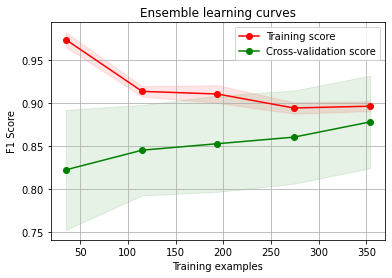

In [493]:
g = plot_learning_curve(clf,"Ensemble learning curves",sparse_X_train,y_train,cv=kfold)


## 4. Testing the Model

In [495]:
clf.fit(sparse_X_train, y_train);

In [496]:
from sklearn.metrics import f1_score

In [497]:
sns.reset_orig()

**4.1 Classification Report**

In [506]:
y_pred = clf.predict(sparse_X_test)
acc = accuracy_score(y_test,y_pred)
f1score = f1_score(y_test,y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93        67
           1       0.92      0.75      0.83        32

    accuracy                           0.90        99
   macro avg       0.91      0.86      0.88        99
weighted avg       0.90      0.90      0.90        99



**4.2 Confusion Matrix**

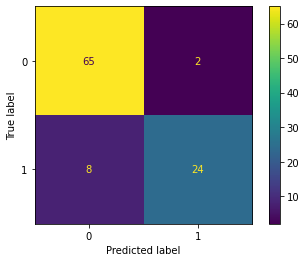

In [505]:
plot_confusion_matrix(clf,sparse_X_test,y_test);

In [499]:
print("Stacked Model\n")
print(f"F1_Score: {round(100*f1score,0)}\n")
print(f"Accuracy: {round(100*acc,0)}\n")


Stacked Model

F1_Score: 83.0

Accuracy: 90.0



**4.3 Misclassified test data**

In [500]:
misclass_ind = [];
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        misclass_ind.append(y_test.index[i])

In [550]:
pd.set_option('mode.chained_assignment','warn')

In [551]:
miss_class_profiles['Pred_Label'] = miss_class_profiles['Label'].map({1:0,0:1})


In [504]:
miss_class_profiles

,Age . Location,Bio,Ques_Ans,Label,Pred_Label
374,25 • Bhubaneshwar,🙃,46,Low Info,NaN
412,27 • Hyderābād,joined this app to get new frds,15,Low Info,NaN
81,27 • Shakūrpur,IG - sakshigotnochill,23,Low Info,NaN
346,26 • Bengaluru,"ʜᴀʀᴅ ᴛᴏ ᴄᴀᴛᴄʜ, ᴇᴀꜱy ᴛᴏ ᴀᴛᴛʀᴀᴄᴛ\nʙᴇᴀᴄʜ ʟᴏᴠᴇʀ, ᴀ...",15,Fake,NaN
308,23 • Utnūr,I @ᗰ TᕼE ᗷE$T OᑎE ᗩᒪᗯᗩY$\nᑭIᑎG ᗰEᕼ Oᑎ ᗰᗩᕼᕼ $$ᗩ...,15,Fake,NaN
65,25 • Hyderābād,want to make new friends,16,Low Info,NaN
24,26 • Gurgaon,I will let you know later,15,Fake,NaN
200,26 • Hyderābād,I m newly here need someone🥰\n(91)....seven on...,15,Fake,NaN
205,21 • Hyderābād,I'm an introvert,15,Ok,NaN
365,26 • Vadodara,Follow ur heart ❤,15,Ok,NaN
